<a href="https://colab.research.google.com/github/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis/blob/master/spoken_digit_rcognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis.git
%cd AudioClassificationWithDeepLearningAnalysis
!pwd

Cloning into 'AudioClassificationWithDeepLearningAnalysis'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 92 (delta 41), reused 28 (delta 5), pack-reused 0
Unpacking objects: 100% (92/92), done.
/content/AudioClassificationWithDeepLearningAnalysis
/content/AudioClassificationWithDeepLearningAnalysis


In [2]:
import numpy as np
import torch
import models
import copy
import torch.nn.functional as F
import torchaudio
import torch.nn as nn
from torch.utils.data import DataLoader,random_split,Dataset
from torchsummary import summary
import torchvision
import torch.utils.tensorboard as tb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import files

In [3]:
#load tensorboard to monitor training
%load_ext tensorboard

writer = tb.SummaryWriter()

def label_to_index(labels, label):
    # Return the position of the word in labels
    return torch.tensor(labels.index(label))

def index_to_label(labels, index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

class SpeechCommandSubDataset(Dataset):
    
    def __init__(self,data,labels):
        self.data = data
        self.labels = labels
            
    def __len__(self):
        return len(self.data)    
    
    def __getitem__(self,idx):
        return self.data[idx], self.labels[idx]

In [4]:
#Loading dataset and custom dataloader
dataset = torchaudio.datasets.SPEECHCOMMANDS('./dataset/data/' , url = 'speech_commands_v0.02', folder_in_archive= 'SpeechCommands',  download = True)
digits = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] 

tensors = []
targets = []

#parameters for MFCC transformation
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

for waveform, sample_rate, label, *_ in dataset:
  if label in digits:
    if sample_rate == 16000:
      if waveform.shape == (1, 16000):
        tensors += [torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=32, 
                                               melkwargs={
                                                            'n_fft': n_fft,
                                                            'n_mels': n_mels,
                                                            'hop_length': hop_length,
                                                            'mel_scale': 'htk',
                                                          }
                                                          )(waveform)]
        targets += [label_to_index(digits, label)]

valid_dataset = SpeechCommandSubDataset(data = tensors, 
                                        labels = targets)

traindata, testdata = random_split(valid_dataset, [round(len(valid_dataset)*.6), round(len(valid_dataset)*.4)])
trainloader = DataLoader(traindata, batch_size=10, shuffle=True)
testloader = DataLoader(testdata, batch_size=10, shuffle=True)

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

(array([3756., 3492., 3525., 3402., 3403., 3727., 3598., 3668., 7057.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <a list of 9 Patch objects>)

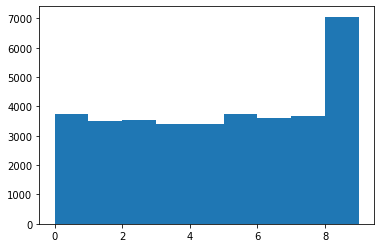

In [5]:
#visualization of dataset
temp_dataset = [targets[index].item() for index in range(len(targets))]
plt.hist(temp_dataset, bins=9)

In [7]:
print("Initializing the neural network...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
model = models.cnnModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epoch = 100
best_accuracy = 0.0
print("Started training !")
for epoch in tqdm(range(num_epoch), total=num_epoch, leave=False):
  running_loss = []
  validation_loss = []
  accuracy = []

  for i, data in tqdm(enumerate(trainloader), total=len(trainloader), leave=False, desc=f'Epoch: {epoch}/{num_epoch}'): 
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    logits = model(inputs) #batch_size x 14
    loss = F.cross_entropy(logits, labels)
    loss.backward() 
    optimizer.step()
    running_loss.append(loss.item())

  print(f'Epoch {epoch}/{num_epoch}... Loss: {sum(running_loss)/len(running_loss)}')
  writer.add_scalars('Loss', {'Train':sum(running_loss)/len(running_loss)}, epoch)

  # Evaluate the model on the test set every 10 epochs
  if epoch % 5 == 0:
    #validation loss and accuracy for novel classes
    with torch.no_grad():
      model.eval()
      for i, data in tqdm(enumerate(testloader), total=len(testloader), leave=False, desc=f'Epoch: {epoch}/{num_epoch}'):
        inputs, labels = data[0].to(device), data[1].to(device)
        logits = model(inputs)
        loss = F.cross_entropy(logits,labels)
        validation_loss.append(loss.item())
        _, pred = logits.max(1)
        acc = (pred == labels).sum().item() / pred.size(0) #pred size= [batch_size, no of classes] e.g(10,14)
        accuracy.append(acc)
      
      batch_validation_loss = sum(validation_loss)/len(validation_loss)
      print(f'Epoch {epoch}/{num_epoch}... Validation loss: {batch_validation_loss}')
      writer.add_scalars('Loss', {'Test':batch_validation_loss}, epoch)
      # Saving model if accuracy on the test set is better than previous best model
      batch_accuracy = sum(accuracy)/len(accuracy)
      print(f'Epoch {epoch}/{num_epoch}... Accuracy: {batch_accuracy}')
      writer.add_scalars('Accuracy', {'Test': batch_accuracy}, epoch)
      
      if batch_accuracy > best_accuracy:
          best_accuracy = batch_accuracy
          torch.save(model.state_dict(), 'checkpoint.pth')
          torch.save(optimizer.state_dict(), 'optimizer_checkpoint.pth')
          print(f'Best model saved at epoch {epoch}/{num_epoch}')

Initializing the neural network...
Device: cuda
Started training !


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0/100:   0%|          | 0/2138 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
files.download('checkpoint.pth')
files.download('optimizer_checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
writer.flush()
writer.close()

In [ ]:
%tensorboard --logdir=runs